In [1]:
!nvidia-smi

Wed Apr  6 03:29:20 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!sudo apt-get install tree -qq > /dev/null

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


In [3]:
#install libraries
!pip install torch==1.5.1+cu101 torchvision==0.6.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html
!pip install numpy==1.17.3
!pip install PyYAML==5.3.1
!pip install git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 704.4 MB 1.3 kB/s 
     |████████████████████████████████| 6.6 MB 35.1 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.5.1+cu101 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.5.1+cu101 which is incompatible.
     |████████████████████████████████| 20.0 MB 1.4 MB/s 
  Attempting uninstall

     |████████████████████████████████| 269 kB 5.3 MB/s 
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp37-cp37m-linux_x86_64.whl size=44636 sha256=8f274922d096f2de205d56e5eba816bf2769147638655f619219738d151f0785
  Stored in directory: /root/.cache/pip/wheels/5e/03/1e/e1e954795d6f35dfc7b637fe2277bff021303bd9570ecea653
Successfully built PyYAML
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-a2f4skno
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-a2f4skno
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=264902 sha256=af4b385c680f7819301413ded4ea069c0590af0364487dad5ab3263f8414132d
  Stored in directory: /tmp/pip-ephem-wheel-cache-cyx3va7d/wheels/e2/6b/1d/344ac773c7495ea0b85eb228bc66daec7400a143a92d36b7b1
Successfully built

**Build the Dataset**

In [3]:
# imports
from pathlib import Path
from tqdm import tqdm
import numpy as np
import json
import urllib
import PIL.Image as Image
import cv2
import torch
import torchvision
from IPython.display import display
from sklearn.model_selection import train_test_split
import os
import PIL

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 16, 10

np.random.seed(42)

In [4]:
# our data directories
!tree weapon -L 2

weapon
├── images
│   ├── train
│   └── val
├── images_new
│   ├── train
│   └── val
├── lables
│   ├── train
│   └── val
└── lables_new
    ├── train
    └── val

12 directories, 0 files


#Normalize the image's Bounding Box
- One txt with labels file per image
- One row per object
- Each row contains: `class_index bbox_x_center bbox_y_center bbox_width bbox_height`
- Box coordinates must be normalized between 0 and 1


In [5]:
!cat weapon/lables/val/1.txt

1
76 45 146 87


In [6]:
#
img = cv2.imread('/content/weapon/images/train/101.jpeg', cv2.IMREAD_UNCHANGED)
dimensions = img.shape
# height, width, number of channels in image
height = img.shape[0]
width = img.shape[1]
channels = img.shape[2]

print('Image Dimension    : ',dimensions)
print('Image Height       : ',height)
print('Image Width        : ',width)
print('Number of Channels : ',channels)

Image Dimension    :  (168, 300, 3)
Image Height       :  168
Image Width        :  300
Number of Channels :  3


In [7]:
# sources path
images_train_path = '/content/weapon/images/train'
images_val_path = '/content/weapon/images/val'
labels_train_path = '/content/weapon/lables/train'
labels_val_path = '/content/weapon/lables/val'

Images = []
Labels = []
Targets = []

# import the data into the lists

for path in sorted(os.listdir(images_train_path)):
    img_path = os.path.join(images_train_path, path)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    Images.append(img)
  
for path in sorted(os.listdir(images_val_path)):
    img_path = os.path.join(images_val_path, path)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    Images.append(img)

for path in sorted(os.listdir(labels_train_path)):
    label_path = os.path.join(labels_train_path, path)
    ls = None
    with open(label_path, 'r') as label_file:
        ls = label_file.read().splitlines()
    
    boxes = []
    for i in range(1, int(ls[0])+1):
        x = [int(j) for j in ls[i].split()]
        boxes.append(x)
    Labels.append(boxes)

for path in sorted(os.listdir(labels_val_path)):
    label_path = os.path.join(labels_val_path, path)
    ls = None
    with open(label_path, 'r') as label_file:
        ls = label_file.read().splitlines()
    
    boxes = []
    for i in range(1, int(ls[0])+1):
        x = [int(j) for j in ls[i].split()]
        boxes.append(x)
    Labels.append(boxes)

In [8]:
len(Images), len(Labels)

(333, 333)

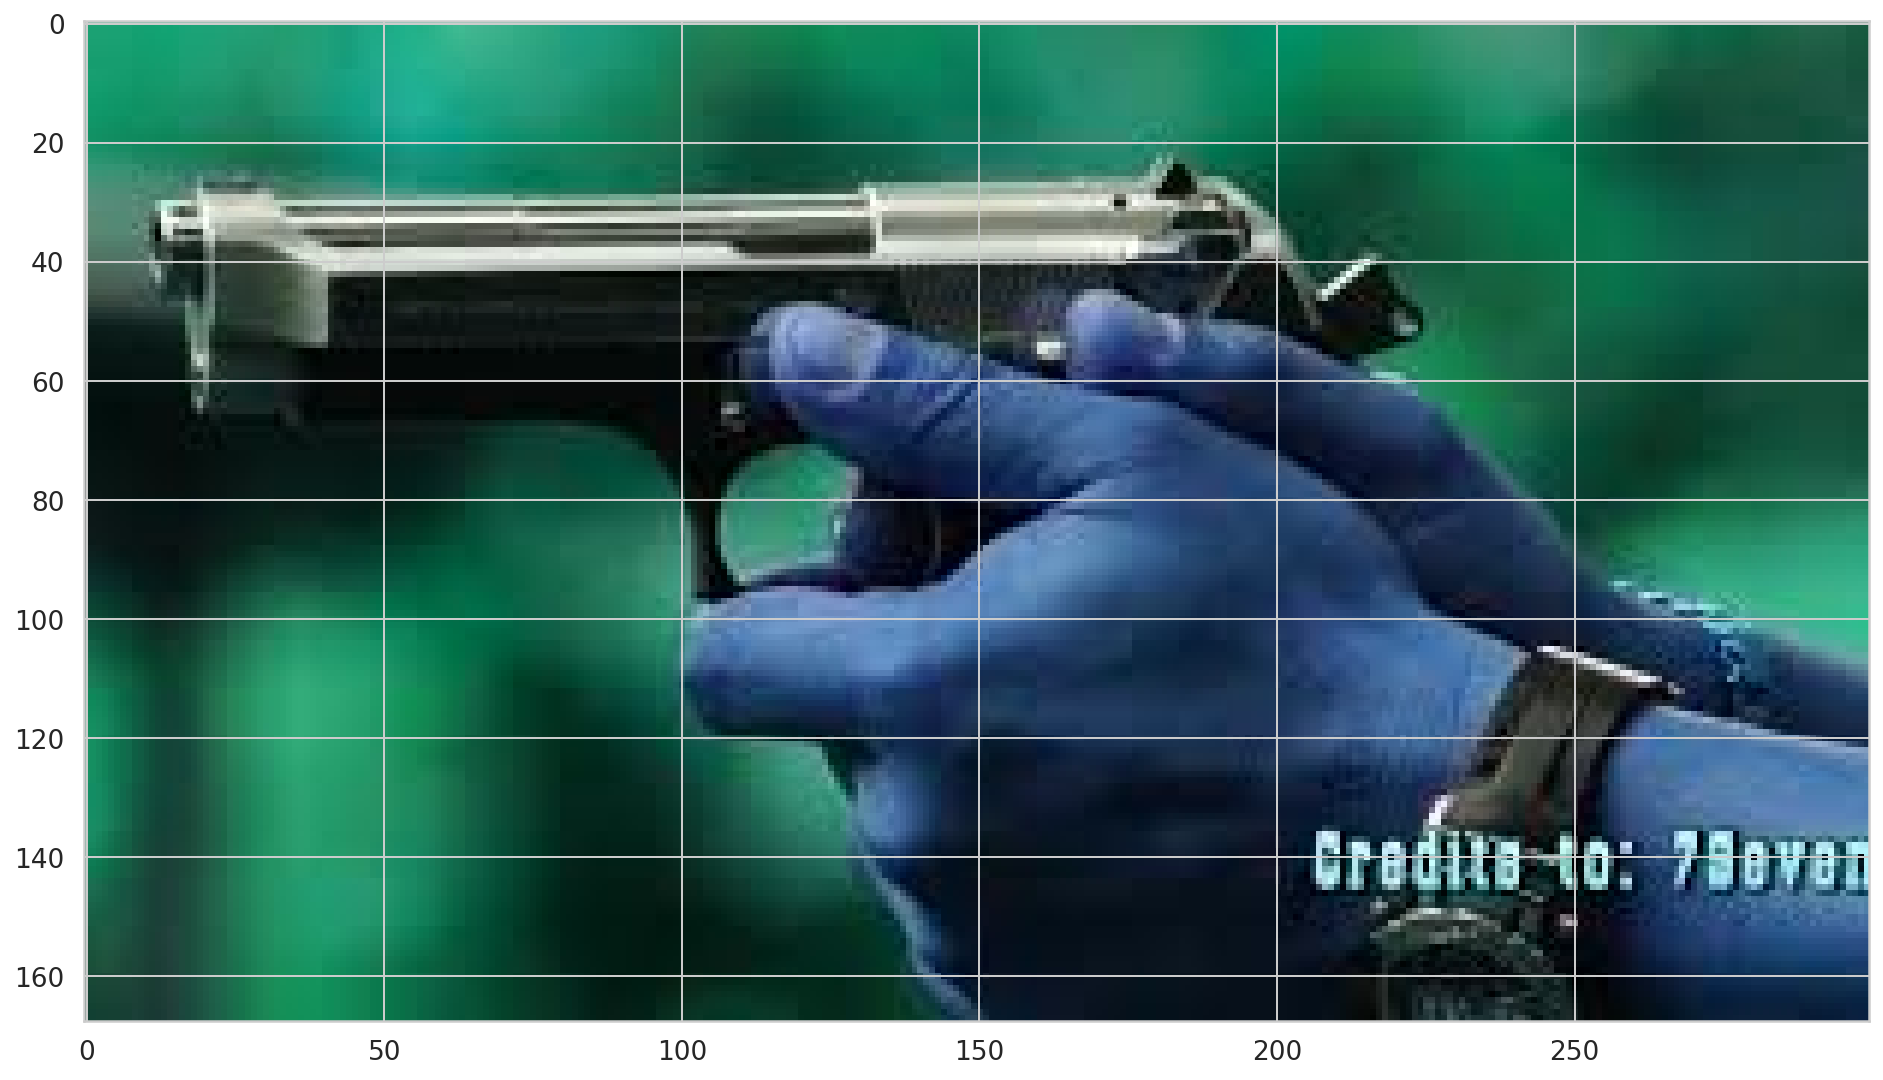

In [9]:
img = cv2.imread('/content/weapon/images/train/100.jpeg', cv2.IMREAD_UNCHANGED)
plt.imshow(img)

(416, 416, 3)


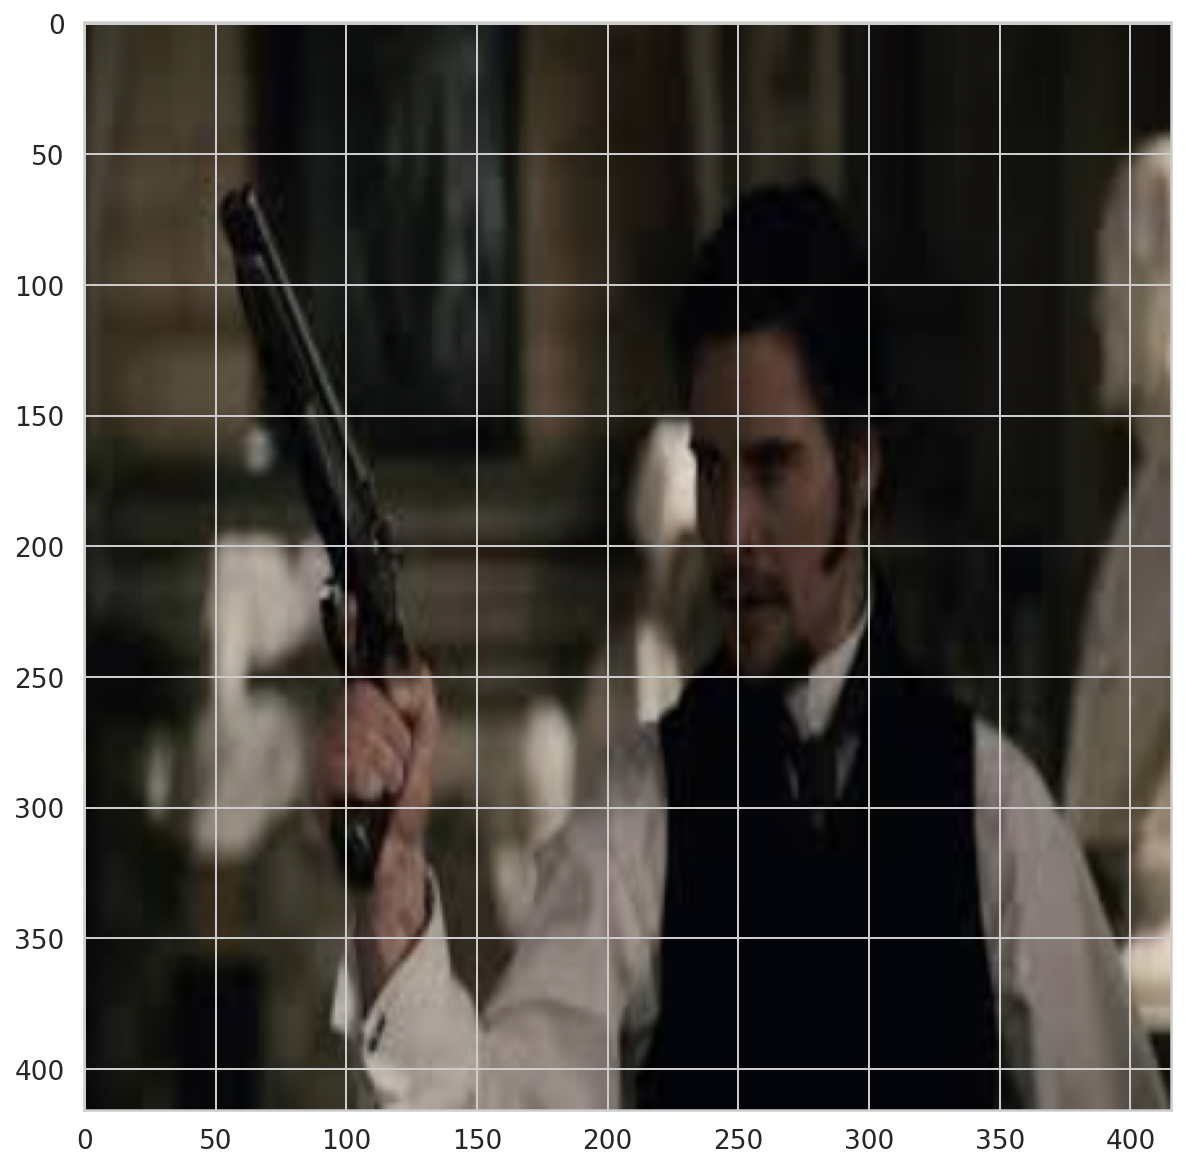

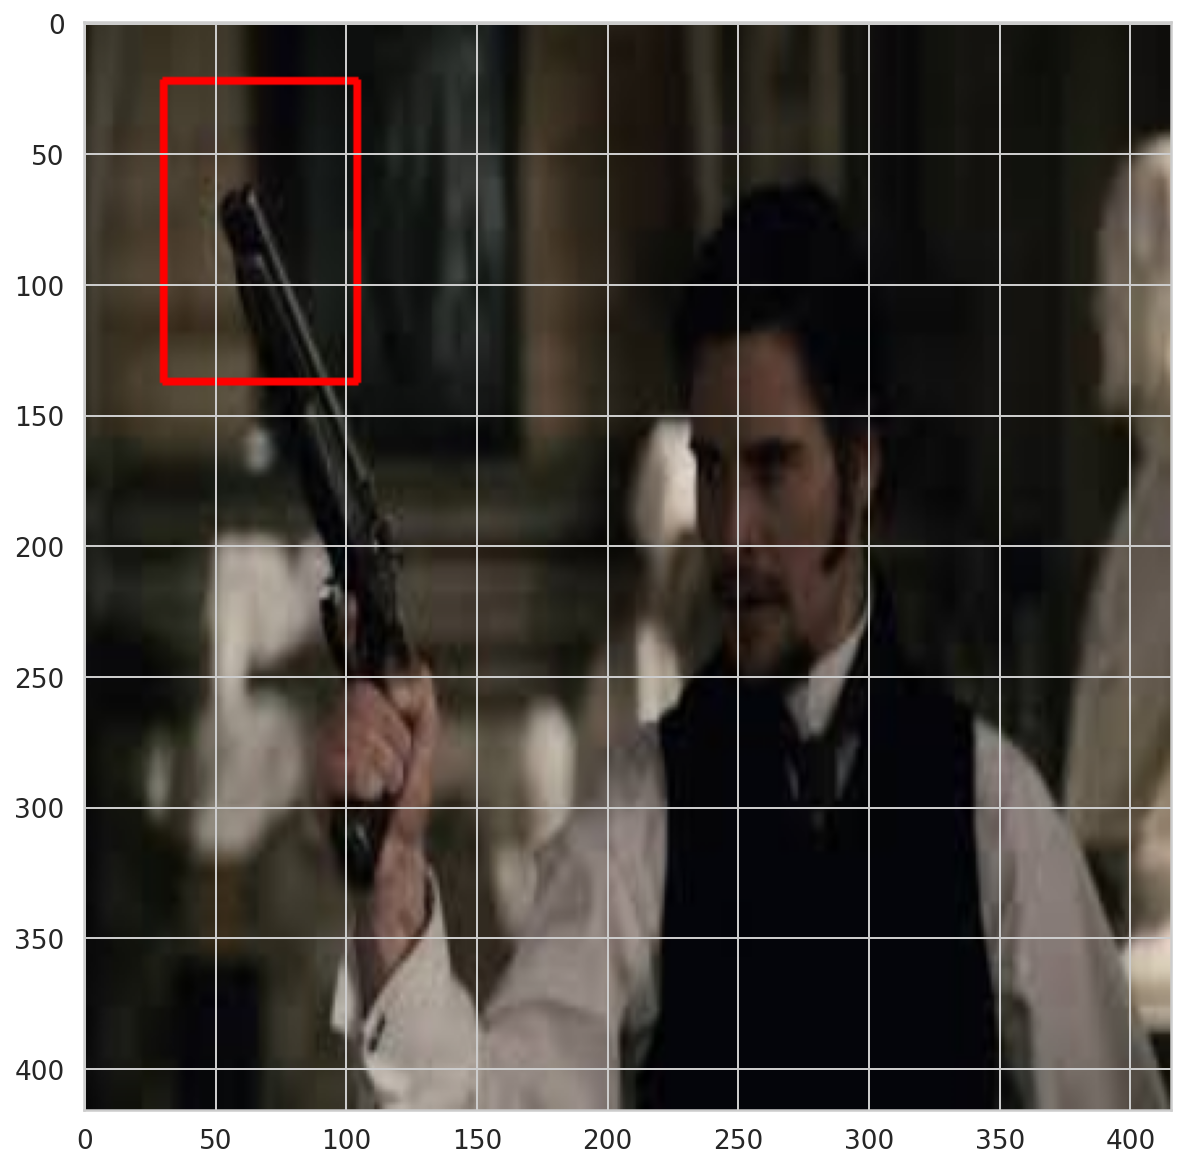

In [44]:
# change the shape of the pictures to 460x460

ls = Labels[-1]
img = Images[-1]
h, w = img.shape[:2]
print(img.shape)
# show the old version of the photo (probably not 460x460)
plt.imshow(img)
plt.show()

# resize the picture to 460x460
img = cv2.resize(img, (416, 416))
for i in range(len(ls)):
    img = cv2.rectangle(img, (int(ls[i][0] * (416/w)), int(ls[i][1] * (416/h))), (int(ls[i][2] * (416/w)), int(ls[i][3] * (416/h))), (255, 0, 0), 2)
# show the new version of the photo (460x460) and add the bounding box
plt.imshow(img)
plt.show()

# do so for each picture in the dataset
for i in range(len(Images)):
    img = Images[i]
    boxes = Labels[i]
    h, w = img.shape[:2]
    img = cv2.resize(img, (416, 416))
    Images[i] = img

    if i < 332 - 34:
      cv2.imwrite(f'/content/weapon/images/train/{i}.jpg', img)
    else:
      cv2.imwrite(f'/content/weapon/images/val/{i}.jpg', img)
    target = np.zeros((13, 13, 5))
    
    # update the bounding box values
    for box in boxes:
        x1, y1, x2, y2 = int(box[0]*(416/w)), int(box[1]*(416/h)), int(box[2]*(416/w)), int(box[3]*(416/h))
        cx, cy = int((x1 + x2)/2), int((y1 + y2)/2)
        bx, by = x2 - x1, y2 - y1
        target_input = [0, cx/416, cy/416, bx/416, by/416]
        #print(target_input)
        if i < 332 - 34:
            with open(f'/content/weapon/lables/train/{i}.txt', 'w') as f:
                for v in target_input:
                  f.write(str(v) + " ")
        else:
             with open(f'/content/weapon/lables/val/{i}.txt', 'w') as f:
                for v in target_input:
                  f.write(str(v) + " ")
        

In [11]:
# now the data is in YOLO format [num_of_classes_in_pic [x_center, y_center, width, height]]
!cat /content/weapon/lables_new/train/100.txt

1 0.5144230769230769 0.23076923076923078 0.14423076923076922 0.10096153846153846 

In [12]:
# our data directories
!tree weapon -L 2

weapon
├── images
│   ├── train
│   └── val
├── images_new
│   ├── train
│   └── val
├── lables
│   ├── train
│   └── val
└── lables_new
    ├── train
    └── val

12 directories, 0 files


#YOLO v5 project setup 

In [21]:
# cloning the git repo
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!git checkout 741fac815e366d74eed020efb8c68a23828ee3e9

Cloning into 'yolov5'...
remote: Enumerating objects: 12530, done.
remote: Total 12530 (delta 0), reused 0 (delta 0), pack-reused 12530
Receiving objects: 100% (12530/12530), 11.61 MiB | 24.76 MiB/s, done.
Resolving deltas: 100% (8720/8720), done.
/content/yolov5444/yolov5/yolov5
Note: checking out '741fac815e366d74eed020efb8c68a23828ee3e9'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at 741fac8 fix: disable usage of root logger (#7296)


In [45]:
!python train.py --img 480 --batch 4 --epochs 15 --data ./data/weapon.yaml --cfg ./models/yolov5x.yaml --weights yolov5x.pt --name yolov5x_weapon

train: weights=yolov5x.pt, cfg=./models/yolov5x.yaml, data=./data/weapon.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=15, batch_size=4, imgsz=480, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=yolov5x_weapon, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: ⚠️ YOLOv5 is out of date by 1 commit. Use `git pull` or `git clone https://github.com/ultralytics/yolov5` to update.
YOLOv5 🚀 v6.1-104-g741fac8 torch 1.11.0+cu102 CUDA:0 (Tesla K80, 11441MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, 

In [36]:
!cd ..
!ls
!tree


CONTRIBUTING.md  export.py   __pycache__       train.py
data		 hubconf.py  README.md	       tutorial.ipynb
detect.py	 LICENSE     requirements.txt  utils
Dockerfile	 models      setup.cfg	       val.py
.
├── CONTRIBUTING.md
├── data
│   ├── Argoverse.yaml
│   ├── coco128.yaml
│   ├── coco.yaml
│   ├── GlobalWheat2020.yaml
│   ├── hyps
│   │   ├── hyp.Objects365.yaml
│   │   ├── hyp.scratch-high.yaml
│   │   ├── hyp.scratch-low.yaml
│   │   ├── hyp.scratch-med.yaml
│   │   └── hyp.VOC.yaml
│   ├── images
│   │   ├── bus.jpg
│   │   └── zidane.jpg
│   ├── Objects365.yaml
│   ├── scripts
│   │   ├── download_weights.sh
│   │   ├── get_coco128.sh
│   │   └── get_coco.sh
│   ├── SKU-110K.yaml
│   ├── VisDrone.yaml
│   ├── VOC.yaml
│   ├── weapon.yaml
│   └── xView.yaml
├── detect.py
├── Dockerfile
├── export.py
├── hubconf.py
├── LICENSE
├── models
│   ├── common.py
│   ├── experimental.py
│   ├── hub
│   │   ├── anchors.yaml
│   │   ├── yolov3-spp.yaml
│   │   ├── yolov3-tiny.yaml
│   │   

In [33]:
!ls

CONTRIBUTING.md  export.py   __pycache__       train.py
data		 hubconf.py  README.md	       tutorial.ipynb
detect.py	 LICENSE     requirements.txt  utils
Dockerfile	 models      setup.cfg	       val.py
